In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

Load the CIFAR-10 database

In [14]:
#Loading dataset

(trainX, trainY), (testX, testY) = cifar10.load_data()

In [15]:
#Analyzing shape of data
print('training set ', '\nData :', trainX.shape, '\nLabel :', trainY.shape)

print('\ntest set', '\nData :', testX.shape, '\nLabel :', testY.shape)

training set  
Data : (50000, 32, 32, 3) 
Label : (50000, 1)

test set 
Data : (10000, 32, 32, 3) 
Label : (10000, 1)


Print sample images

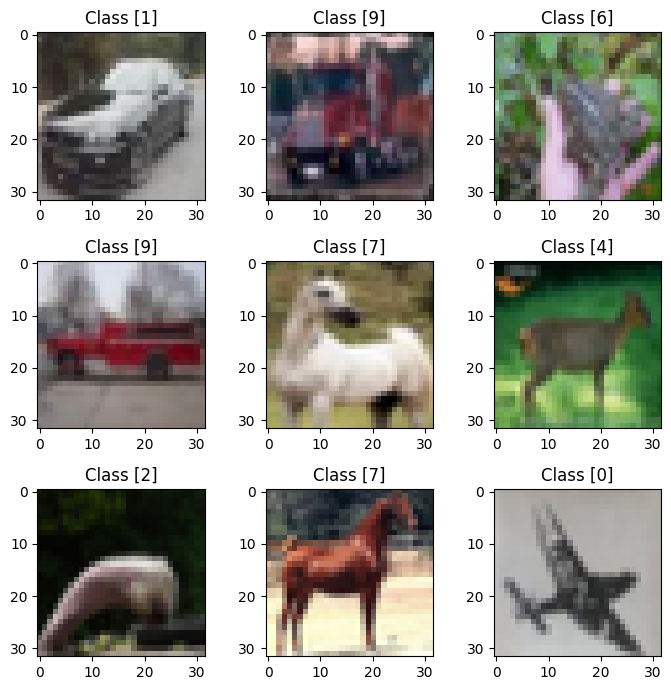

In [16]:
#img = plt.imshow(trainX[1])
from numpy import random

plt.rcParams['figure.figsize'] = (7,7)

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(trainX))
    plt.imshow(trainX[num], cmap='gray')
    plt.title("Class {}".format(trainY[num]))
    
plt.tight_layout()

Pre-processing step

In [17]:
#One Hot Encoding Labels from Train and Test Dataset
from tensorflow.keras.utils import to_categorical

trainX = trainX.astype('float32')   # change integers to 32-bit floating point numbers
testX = testX.astype('float32')

trainX /= 255                        # normalize the input
testX /= 255

trainY_one_hot = to_categorical(trainY)
testY_one_hot = to_categorical(testY)

In [18]:
print(trainY_one_hot[1,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Load the pretarined MobileNet model

In [19]:
#Initializing MobileNet as Base Model for Transfer Learning

from tensorflow.keras.applications import MobileNet

pretrained_model = MobileNet(include_top=False, weights='imagenet',
            input_shape=(32,32,3))

17225924/17225924 [==============================] - 0s 0us/step


In [20]:
pretrained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                         

Define the base layer

In [21]:
#Adding layers to base model of MobileNet

def base_model():

  model = Sequential()
  model.add(Dropout(0.3, input_shape = (1, 1, 1024)))
  model.add(Flatten())

  #Adding the Dense Layers and Dropout
  #model.add(Dense(512,activation=('relu'))) 

  model.add(Dense(128,activation=('relu'))) 

  model.add(Dropout(.3))

  model.add(Dense(10,activation=('softmax')))
  return model

In [22]:
#Visualizing Model Summary

y = pretrained_model
basemodel = base_model()
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1, 1, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


In [23]:
pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


Define the complete model with quantization aware training

In [24]:
#pretrained_model = MobileNet(input_shape=(32, 32, 3), weights='imagenet', include_top=False)
import tensorflow_model_optimization as tfmot

pretrained_model.trainable = True
    
# for layer in pretrained_model.layers[:-1]:
#     layer.trainable = False
    
q_pretrained_model = tfmot.quantization.keras.quantize_model(pretrained_model)
q_base_model = tfmot.quantization.keras.quantize_model(basemodel)
   
original_inputs = tf.keras.layers.Input(shape=(32, 32, 3))
y = q_pretrained_model(original_inputs)
original_outputs = q_base_model(y)

model = tf.keras.Model(original_inputs, original_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3241000   
 nal)                                                            
                                                                 
 sequential (Sequential)     (None, 10)                132506    
                                                                 
Total params: 3,373,506
Trainable params: 3,339,466
Non-trainable params: 34,040
_________________________________________________________________


Train the model

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])

In [26]:
#Training Model
hist = model.fit(trainX, trainY_one_hot, batch_size = 100, epochs = 20, 
                 validation_split = 0.1)

Epoch 1/20
450/450 [==============================] - 96s 152ms/step - loss: 1.2928 - accuracy: 0.5616 - val_loss: 0.9173 - val_accuracy: 0.6896
Epoch 2/20
450/450 [==============================] - 65s 145ms/step - loss: 0.7857 - accuracy: 0.7414 - val_loss: 0.7263 - val_accuracy: 0.7608
Epoch 3/20
450/450 [==============================] - 63s 141ms/step - loss: 0.6434 - accuracy: 0.7912 - val_loss: 0.6976 - val_accuracy: 0.7656
Epoch 4/20
450/450 [==============================] - 64s 142ms/step - loss: 0.5663 - accuracy: 0.8170 - val_loss: 0.6574 - val_accuracy: 0.7918
Epoch 5/20
450/450 [==============================] - 66s 147ms/step - loss: 0.5018 - accuracy: 0.8363 - val_loss: 0.6962 - val_accuracy: 0.7696
Epoch 6/20
450/450 [==============================] - 64s 142ms/step - loss: 0.4535 - accuracy: 0.8522 - val_loss: 0.6837 - val_accuracy: 0.7892
Epoch 7/20
450/450 [==============================] - 63s 141ms/step - loss: 0.4056 - accuracy: 0.8702 - val_loss: 0.7431 - val_ac

Evaluate the model

In [27]:
#Testing accuracy of trained model

model.evaluate(testX, testY_one_hot)[1]

313/313 [==============================] - 18s 52ms/step - loss: 0.8207 - accuracy: 0.8073


0.8072999715805054

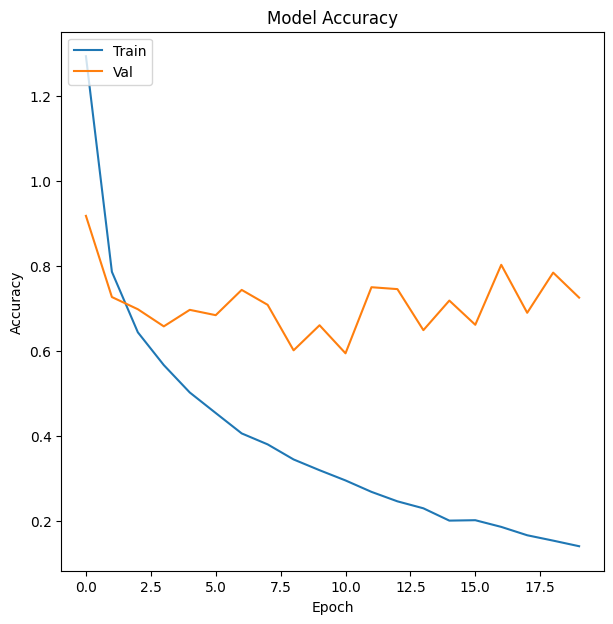

In [28]:
#Visualizing Model Accuracy

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

Convert into TFLite and save

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_qat = converter.convert()

import pathlib

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_qat.tflite"
tflite_model_file.write_bytes(tflite_model_qat)

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


3649952

Evaluate the TFLite model on test set

In [30]:
tflite_model_file = 'tflite_models/model_qat.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in testX:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 3)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(testY_one_hot[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print(accuracy)

0.8065


Create sample JPG files to test on Raspberry Pi

In [33]:
from numpy import random

from PIL import Image

(trainX, trainY), (testX, testY) = cifar10.load_data()

for i in range(10):
    num = random.randint(0, len(testX))
    im = Image.fromarray(testX[num])
    im.save('sample' +str(i+1)+'.jpg')

In [34]:
tflite_model_file = 'tflite_models/model_qat.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

Im = Image.open('sample3.jpg')
Im_resized = Im.resize((32, 32))
Im = np.asarray(Im_resized)

Im = Im/255

input_data = np.array(Im, dtype=np.float32)

input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 3)

interpreter.set_tensor(input_index, input_data)
interpreter.invoke()
prediction = interpreter.get_tensor(output_index)
prediction = np.argmax(prediction)


print(prediction)

6
